In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam

In [8]:
# Collecting Image Paths
image_paths = []
for root, dirs, files in os.walk('./COVID-19_Radiography_Dataset'):
    if 'images' in root:
        for file in files:
            if file.endswith('png'):
                image_paths.append(os.path.join(root, file))
print(f'Found {len(image_paths)} image paths.')

# Processing Images and Labels
images = []
labels_list = []
img_size = 64  # Changed from 128 to 64
category_map = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}
for path in tqdm(image_paths):
    category = path.split(os.path.sep)[-3]
    if category in category_map:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size)) / 255.0
        images.append(img)
        labels_list.append(category_map[category])
print(f'Processed {len(images)} images with labels.')

Found 21165 image paths.


100%|█████████████████████████████████████████████████████████| 21165/21165 [00:44<00:00, 480.38it/s]

Processed 15153 images with labels.


In [9]:
# Encoding the Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_list)
encoded_labels = keras.utils.to_categorical(encoded_labels, num_classes=3)
print('Classes:', label_encoder.classes_)
print('Sample encoded label:', encoded_labels[0])

Classes: ['Covid-19' 'Normal' 'Pneumonia']
Sample encoded label: [1. 0. 0.]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

X_train = np.array(X_train, dtype=np.float32)  # Specify float32
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

print('Training set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (9697, 64, 64, 3)
Validation set shape: (2425, 64, 64, 3)
Testing set shape: (3031, 64, 64, 3)


In [13]:
# Constructing the CNN Model
input_shape = (64, 64, 3)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),  # This layer now accepts 1024 features
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 520,003 (1.98 MB)

 Trainable params: 520,003 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7664 - loss: 0.5311 - val_accuracy: 0.8602 - val_loss: 0.3418
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8596 - loss: 0.3400 - val_accuracy: 0.8800 - val_loss: 0.3034
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8896 - loss: 0.2743 - val_accuracy: 0.9006 - val_loss: 0.2343
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9143 - loss: 0.2249 - val_accuracy: 0.9287 - val_loss: 0.1847
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9278 - loss: 0.1796 - val_accuracy: 0.9274 - val_loss: 0.1928
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9386 - loss: 0.1589 - val_accuracy: 0.9369 - val_loss: 0.1647
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9490 - loss: 0.1371 - val_accuracy: 0.9464 - val_loss: 0.1486
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9589 - loss: 0.1012 - 

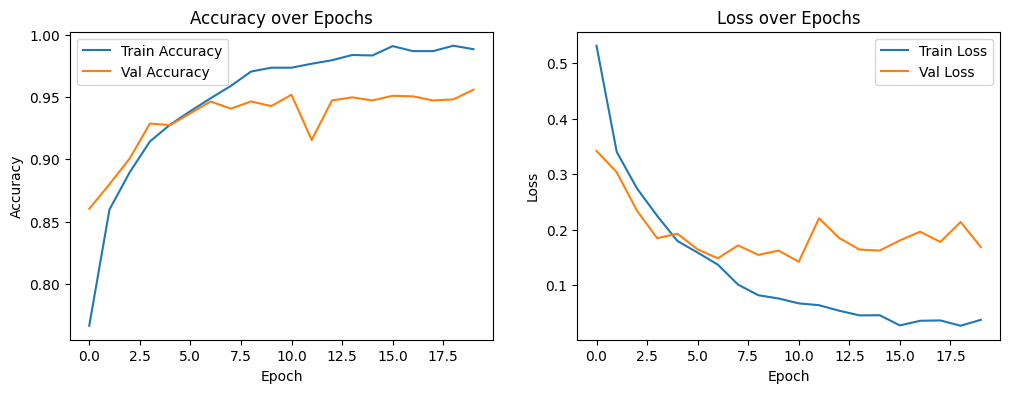

In [14]:
epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

# Visualizing Training Progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


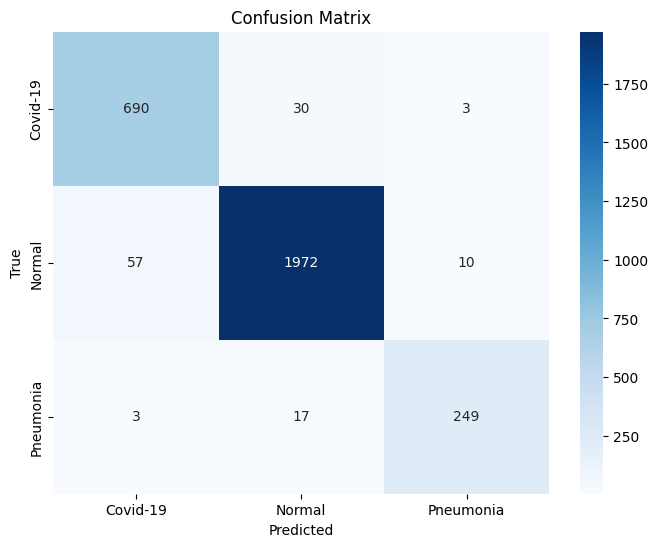

              precision    recall  f1-score   support

    Covid-19       0.92      0.95      0.94       723
      Normal       0.98      0.97      0.97      2039
   Pneumonia       0.95      0.93      0.94       269

    accuracy                           0.96      3031
   macro avg       0.95      0.95      0.95      3031
weighted avg       0.96      0.96      0.96      3031



In [15]:
# Evaluating the Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

In [26]:
import logging

models_dir = 'models'
logging.info(f"Creating models directory: {models_dir}")
os.makedirs(models_dir, exist_ok=True)

label_encoder_path = os.path.join(models_dir, 'Label_encoder.pkl')
try:
    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)
    logging.info(f"Label encoder saved to {label_encoder_path}")
except Exception as e:
    logging.error(f"Failed to save label encoder: {e}")
    raise

# Verify the file exists
if os.path.exists(label_encoder_path):
    logging.info(f"Confirmed: {label_encoder_path} exists.")
else:
    logging.error(f"Label encoder file {label_encoder_path} was not created.")
    raise FileNotFoundError(f"Label encoder file {label_encoder_path} was not created.")

In [31]:
from tensorflow.keras.models import load_model
import pickle

le = pickle.load(open("./models/Label_encoder.pkl",'rb'))
model = load_model('CNN_Covid19_Xray_Version.h5')


In [32]:
# Save the model
model.save('CNN_Covid19_Xray_Version.h5')
print('Model saved to models/CNN_Covid19_Xray_Version.h5')



Model saved to models/CNN_Covid19_Xray_Version.h5


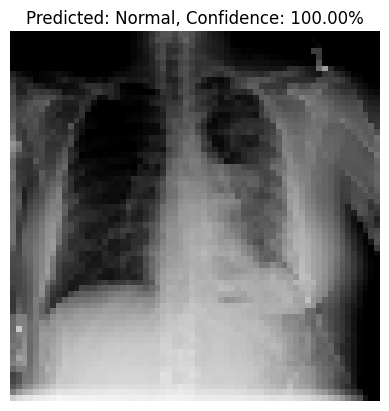

Predicted Label: Normal, Confidence Score: 100.00%


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def detection_system(image_path, model, label_encoder, image_size=64):
    """
    Detection system function to classify a chest X-ray image for COVID-19, Normal, or Pneumonia.

    Parameters:
    - image_path (str): Path to the input image.
    - model: Trained Keras model for classification.
    - label_encoder: LabelEncoder object used to encode/decode class labels.
    - image_size (int): Target size for resizing the image (default: 64 to match training).

    Returns:
    - predicted_label (str): Predicted class label (e.g., 'Covid-19', 'Normal', 'Pneumonia').
    - confidence_score (float): Confidence score of the predicted class (in percentage).

    Raises:
    - ValueError: If the image cannot be loaded from the provided path.
    """
    logging.info(f"Processing image: {image_path}")
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        logging.error(f"Image not found at path: {image_path}")
        raise ValueError(f"Image not found at path: {image_path}")

    # Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize to match training image size
    image_resized = cv2.resize(image_rgb, (image_size, image_size))

    # Normalize pixel values to [0, 1] and use float32
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Add batch dimension for model input
    image_input = np.expand_dims(image_normalized, axis=0)

    # Make prediction
    logging.info("Making prediction...")
    predictions = model.predict(image_input, verbose=0)

    # Get predicted class index and confidence score
    predicted_index = np.argmax(predictions)
    confidence_score = predictions[0][predicted_index] * 100  # Convert to percentage

    # Decode predicted index to label
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    logging.info(f"Predicted: {predicted_label}, Confidence: {confidence_score:.2f}%")

    # Visualize the result (optional, can be disabled for Flask)
    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score

# Example usage (for standalone testing)
if __name__ == "__main__":
    from tensorflow.keras.models import load_model
    import pickle

    # Load model and label encoder
    model_path = 'CNN_Covid19_Xray_Version.h5'
    label_encoder_path = 'models/Label_encoder.pkl'
    try:
        model = load_model(model_path)
        le = pickle.load(open(label_encoder_path, 'rb'))
    except FileNotFoundError as e:
        logging.error(f"File not found: {e}")
        raise

    # Replace with your image path
    image_path = "./Lung_Opacity-1.png"  # Update with actual path
    try:
        predicted_label, confidence_score = detection_system(image_path, model, le)
        print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score:.2f}%")
    except ValueError as e:
        print(f"Error: {e}")

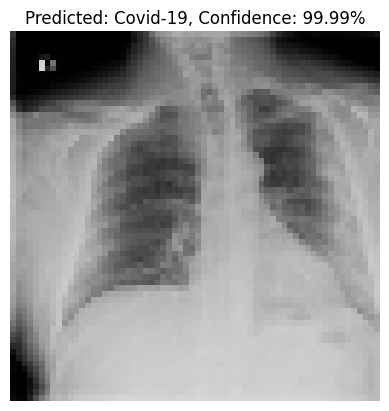

Predicted Label: Covid-19, Confidence Score: 99.99%


In [41]:
if __name__ == "__main__":
    from tensorflow.keras.models import load_model
    import pickle

    # Load model and label encoder
    model_path = 'CNN_Covid19_Xray_Version.h5'
    label_encoder_path = 'models/Label_encoder.pkl'
    try:
        model = load_model(model_path)
        le = pickle.load(open(label_encoder_path, 'rb'))
    except FileNotFoundError as e:
        logging.error(f"File not found: {e}")
        raise

    # Replace with your image path
    image_path = "./COVID-19_Radiography_Dataset/COVID/images/COVID-1019.png"  # Update with actual path
    try:
        predicted_label, confidence_score = detection_system(image_path, model, le)
        print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score:.2f}%")
    except ValueError as e:
        print(f"Error: {e}")